Collecting data of top 100 tv series from imdb website using beautiful soup

In [1]:
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re, pickle, copy, time

In [2]:
top250_html= urlopen("http://www.imdb.com/chart/toptv/?sort=rk,asc&mode=simple&page=1") ##link to imdb top250 tvseries page
top250= bs(top250_html, "lxml")

In [3]:
'''scaping the top250 tvseries page and take out links to each tvseries listed there'''
tvs_html=[]
for tvs in top250.find_all("td", class_= "titleColumn"):  
    tvs_html.append("http://www.imdb.com"+ re.findall(r'/title/\w+/', tvs.a["href"])[0])

In [5]:
t1= time.time()
bs1= bs(urlopen('http://www.imdb.com/title/tt0749451/?ref_=ttep_ep1'),"lxml")
t2= time.time()
t2-t1

In [4]:
def get_tvSeasons(tv_url):
    '''takes in a url of the main page of a tvseries and will return a dictionary of all urls of all seasons of that tvseries 
    with their season no as its key'''
    
    tv_soup= bs(urlopen(tv_url),'lxml')   #opening tvseries main page
    
    #collecting tv series name and tvseries overall rating
    tvSeriesName= tv_soup.find_all("div", {"class":"title_wrapper"})[0].find_all("h1", {"itemprop":"name"})[0].text.strip() 
    tvSeriesRating= tv_soup.find_all("div", {"class":"ratingValue"})[0].find_all("span", \
                                                                                 {"itemprop":"ratingValue"})[0].text.strip()
    
    tv_Seasonslink={}
    '''I tried to run below code to get url of all seasons, but it didn't work out universally, 
    since few of the tvseries had had not listed all the seasons in the main page'''
#     for tagk in tv_soup.find_all("div", class_= "seasons-and-year-nav"):
#         tagk_child= tagk.findChildren("div")[2]
#         for tagk_child2 in tagk_child.find_all("a"):
#             tv_Seasonslink["Season"+ str(tagk_child2.text)]= "http://www.imdb.com"+\
#             re.findall(r'(.+)&.+',tagk_child2.get("href"))[0]

    '''Thus I tried to open one season link and collected urls of all other seasons from that page'''
    helper_link= "http://www.imdb.com"+re.findall(r'(.+)&.+',tv_soup.find_all("div", class_= "seasons-and-year-nav")[0].\
       findChildren("div")[2].find_all("a")[0].get("href"))[0] 
    
    helper_linksoup= bs(urlopen(helper_link),'lxml')  #opening that helper link
    
    initial_= re.findall(r'(http://www\..+season=)\d+',helper_link)[0] 
    #saved the initial from the helper link, since all other seasons could be traced using the drill down option in that page
    
    for epi in helper_linksoup.find_all('select', {'id':'bySeason'})[0].find_all('option'):
        tv_Seasonslink["Season"+ str(epi.text.strip())] = initial_ + str(epi.get('value').strip())
    
    return tvSeriesName,tvSeriesRating, tv_Seasonslink  

In [7]:
'''A demo of what the above function returns and how much time it took to collect information of seasons url'''
t1= time.time()
testName, testRating, testSeasonlink= get_tvSeasons(tvs_html[5])  ##The Wire
t2= time.time()
print("Time took to collect",len(testSeasonlink), "seasons url:",t2-t1,"s")

Time took to collect 5 seasons url: 10.628212451934814 s


In [12]:
print("Season Name: {0} with rating {1} ".format(testName, testRating))
print("Seasons link")
testSeasonlink

Season Name: The Wire with rating 9.3 
Seasons link


{'Season1': 'http://www.imdb.com/title/tt0306414/episodes?season=1',
 'Season2': 'http://www.imdb.com/title/tt0306414/episodes?season=2',
 'Season3': 'http://www.imdb.com/title/tt0306414/episodes?season=3',
 'Season4': 'http://www.imdb.com/title/tt0306414/episodes?season=4',
 'Season5': 'http://www.imdb.com/title/tt0306414/episodes?season=5'}

In [13]:
def get_tvEpisodes(tvSeasons_url):
    '''takes in a dictionary of of all seasons and would return a dictionary of all episodes link contained in the seasons'''
    tv_episodeslink= {}
    for seasony in tvSeasons_url:
        tv_episodeslink[seasony]= []
        tv_season_soup= bs(urlopen(tvSeasons_url[seasony]), "lxml")
        for episodek in tv_season_soup.find_all('div', class_= "info"):
                try:
                    tv_episodeslink[seasony].append("http://www.imdb.com"+episodek.strong.a["href"])
                except:
                    ValueError(seasony+" in the making")
        
    return tv_episodeslink

In [16]:
t1= time.time()
testepisodes= get_tvEpisodes(testSeasonlink)
t2= time.time()
print("Time took to collect",sum([len(episod) for _,episod in testepisodes.items()]), "episodes url:",t2-t1,"s")

Time took to collect 60 episodes url: 17.930255889892578 s


In [18]:
testepisodes["Season1"]

['http://www.imdb.com/title/tt0749451/?ref_=ttep_ep1',
 'http://www.imdb.com/title/tt0749448/?ref_=ttep_ep2',
 'http://www.imdb.com/title/tt0749446/?ref_=ttep_ep3',
 'http://www.imdb.com/title/tt0749437/?ref_=ttep_ep4',
 'http://www.imdb.com/title/tt0749450/?ref_=ttep_ep5',
 'http://www.imdb.com/title/tt0749452/?ref_=ttep_ep6',
 'http://www.imdb.com/title/tt0749438/?ref_=ttep_ep7',
 'http://www.imdb.com/title/tt0749433/?ref_=ttep_ep8',
 'http://www.imdb.com/title/tt0749429/?ref_=ttep_ep9',
 'http://www.imdb.com/title/tt0749447/?ref_=ttep_ep10',
 'http://www.imdb.com/title/tt0749449/?ref_=ttep_ep11',
 'http://www.imdb.com/title/tt0749424/?ref_=ttep_ep12',
 'http://www.imdb.com/title/tt0749441/?ref_=ttep_ep13']

In [19]:
def get_Episodedetails(tv_episodesurl):
    '''takes in a dictionary of episodes url and returns a dictionary with all relevant information related to that episode'''
    epi_info={}
    #would be each data type in a list
    epi_info["title"] = []
    epi_info["airdate"] = []
    epi_info["rating"] = []
    epi_info["usersCount"] = []
    epi_info["duration"] = []
    epi_info["episode"] = []
    epi_info["genre"] = []
    
#     total_time=[]
#     i=0
    for seasonr in tv_episodesurl: #iterate over seasons
        for epilink in tv_episodesurl[seasonr]:  #iterate over episodes in that season
#             tx= time.time()
            epi_html= urlopen(epilink)
            epi_soup= bs(epi_html, 'lxml')
            
            try:
                epi_info["rating"].append(epi_soup.find_all("div",class_= "title_bar_wrapper")[0].\
                                          findChildren("span", {"itemprop": "ratingValue"})[0].text.strip())
                epi_info["usersCount"].append(epi_soup.find_all("div",class_= "title_bar_wrapper")[0].\
                                         findChildren("span", {"itemprop": "ratingCount"})[0].text.strip())
                genre_list=[]
                for genre in epi_soup.find_all("div",class_= "title_bar_wrapper")[0].findChildren("span", {"itemprop": "genre"}):
                    genre_list.append(genre.text.strip())
                epi_info["genre"].append(genre_list)
                epi_info["title"].append(epi_soup.find_all("div",class_= "title_bar_wrapper")[0].\
                                         findChildren("h1", {"itemprop":"name"})[0].text.strip())
                epi_info["duration"].append(epi_soup.find_all("div",class_= "title_bar_wrapper")[0].\
                                            findChildren("time", {"itemprop":"duration"})[0].text.strip())
                epi_info["airdate"].append(epi_soup.find_all("div",class_= "title_bar_wrapper")[0].\
                                           findChildren("meta", {"itemprop":"datePublished"})[0].get("content").strip())
                epi_info["episode"].append(epi_soup.find_all("div",class_= "button_panel navigation_panel")[0].\
                                           findChildren("div", {"class":"bp_heading"})[0].text.strip())
            except:
                ValueError(seasonr+" in the making")
#             ty= time.time()
#             delt= ty-tx
#             print("time took to get details of ", epi_info["episode"][i], " : ", delt, " sec")
#             total_time.append(delt)
#             i+=1
        
        ## this is to assure all information fetched is correct
        assert(len(epi_info["rating"])==len(epi_info["genre"]))
        assert(len(epi_info["rating"])==len(epi_info["title"]))
        assert(len(epi_info["rating"])==len(epi_info["duration"]))
        assert(len(epi_info["rating"])==len(epi_info["airdate"]))
        assert(len(epi_info["rating"])==len(epi_info["episode"]))
#     print("total time: ", sum(total_time), " sec")
    return epi_info

In [20]:
t1= time.time()
epi_Det= get_Episodedetails(testepisodes)
t2= time.time()
print("Time took to collect data of",len(epi_Det['episode']), "episodes:",t2-t1,"s")

Time took to collect data of 60 episodes: 411.512727022171 s


In [23]:
'''This is how would collected data would look like'''
epi_Det["airdate"][:5], epi_Det["episode"][:5]

(['2002-06-02', '2002-06-09', '2002-06-16', '2002-06-23', '2002-06-30'],
 ['Season 1 | Episode 1',
  'Season 1 | Episode 2',
  'Season 1 | Episode 3',
  'Season 1 | Episode 4',
  'Season 1 | Episode 5'])

In [24]:
tv100_Data={} #stores all information
tv100_AvgRatingData= {} #stores only overall rating of a tvseries

In [25]:
'''I ran below code in parts of - 5 tvseries at a time, and is advisable to keep saving the data in a pickle 
as soon as it gets collected'''
for tv_url in tvs_html[:100]:
    t1= time.time()
    tvSeries, tvSeriesRating, tvSeasonsUrl= get_tvSeasons(tv_url)
    tv100_Data[tvSeries]= get_Episodedetails(get_tvEpisodes(tvSeasonsUrl))
    tv100_AvgRatingData[tvSeries]= tvSeriesRating
    t2= time.time()
    print("collected for ", tvSeries, ": took ",str(t2-t1))
'''
collected for  Shameless : took  540.6983664035797
collected for  Black Adder the Third : took  34.327576875686646
collected for  Kôdo giasu: Hangyaku no rurûshu : took  292.7091348171234
'''

'\ncollected for  Shameless : took  540.6983664035797\ncollected for  Black Adder the Third : took  34.327576875686646\ncollected for  Kôdo giasu: Hangyaku no rurûshu : took  292.7091348171234\n'

In [26]:
tv50_Data= copy.deepcopy(tv100_Data)
tv50_AvgRatingData= copy.deepcopy(tv100_AvgRatingData)

In [27]:
'''Below code was run during the collection time'''
# tv50Data_picklefile= open("tv50_Data_dict.pickle", "wb+")  #meta data  
# pickle.dump(tv50_Data, tv50Data_picklefile)

# tv50AvgRating_picklefile= open("tv50_AvgRating_dict.pickle", "wb+")  #meta data
# pickle.dump(tv50_AvgRatingData, tv50AvgRating_picklefile)

# tv50Data_picklefile.close()
# tv50AvgRating_picklefile.close()

Once all 100 tv shows data is collected, I have saved it in a pickle file named- tv100_Data_dict.pickle and tv100_AvgRating_dict.pickle. 
I am loading those saved pickle files below

In [28]:
pickle_= open('tv100_Data_dict.pickle','rb')   
tv100_Data= pickle.load(pickle_)
pickle_2= open('tv100_AvgRating_dict.pickle', 'rb')
tv100_AvgRatingData= pickle.load(pickle_2)

In [29]:
def transform_to_df(data_dict):
    '''The function will take in data dictionary collected above ann transforms it into a dataframe'''
    master_df= pd.DataFrame(columns=["TVSeries","airdate", "duration", "episode", "genre", "rating", "title", "usersCount"])
    for seriesi in data_dict:
        series_df= pd.DataFrame.from_dict(data_dict[seriesi], orient="columns")
        series_df["TVSeries"]= seriesi
        master_df= pd.concat([master_df, series_df])
    
    return master_df

In [30]:
got_dict= {"Game of Thrones": tv100_Data["Game of Thrones"]}

In [31]:
got= transform_to_df(got_dict)
got.head()

,TVSeries,airdate,duration,episode,genre,rating,title,usersCount
0,Game of Thrones,2017-07-16,59min,Season 7 | Episode 1,"[Adventure, Drama, Fantasy]",8.7,Dragonstone,"32,783"
1,Game of Thrones,2017-07-23,59min,Season 7 | Episode 2,"[Adventure, Drama, Fantasy]",9.0,Stormborn,"26,921"
2,Game of Thrones,2017-07-30,1h 3min,Season 7 | Episode 3,"[Adventure, Drama, Fantasy]",9.3,The Queen's Justice,"27,877"
3,Game of Thrones,2017-08-06,50min,Season 7 | Episode 4,"[Adventure, Drama, Fantasy]",9.8,The Spoils of War,"58,181"
4,Game of Thrones,2017-08-13,59min,Season 7 | Episode 5,"[Adventure, Drama, Fantasy]",9.0,Eastwatch,"25,820"


In [32]:
got[["Season", "Episode"]]= got.episode.str.extract(r'(.+)\s?\|\s?(.+)', expand=True)
got.drop("episode", inplace=True, axis=1)

got["Season"]= got.Season.str.findall('\d+').apply(lambda x: x[0])
got["Episode"]= got.Episode.str.findall('\d+').apply(lambda x: x[0])

In [33]:
got["rating"]= pd.to_numeric(got["rating"])
got["Episode"]= pd.to_numeric(got["Episode"])

In [34]:
got.head()

,TVSeries,airdate,duration,genre,rating,title,usersCount,Season,Episode
0,Game of Thrones,2017-07-16,59min,"[Adventure, Drama, Fantasy]",8.7,Dragonstone,"32,783",7,1
1,Game of Thrones,2017-07-23,59min,"[Adventure, Drama, Fantasy]",9.0,Stormborn,"26,921",7,2
2,Game of Thrones,2017-07-30,1h 3min,"[Adventure, Drama, Fantasy]",9.3,The Queen's Justice,"27,877",7,3
3,Game of Thrones,2017-08-06,50min,"[Adventure, Drama, Fantasy]",9.8,The Spoils of War,"58,181",7,4
4,Game of Thrones,2017-08-13,59min,"[Adventure, Drama, Fantasy]",9.0,Eastwatch,"25,820",7,5


In [36]:
from ggplot import *

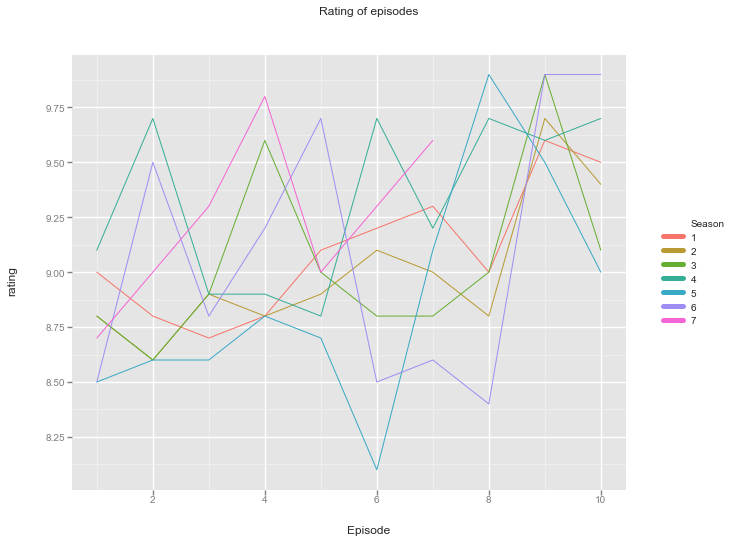

<ggplot: (-9223371879412675794)>

In [39]:
ggplot(data=got, aesthetics= aes(x= "Episode", y= "rating", color="Season")) + geom_line() + ggtitle('Rating of episodes')

Above graph looks messy, as anticipated

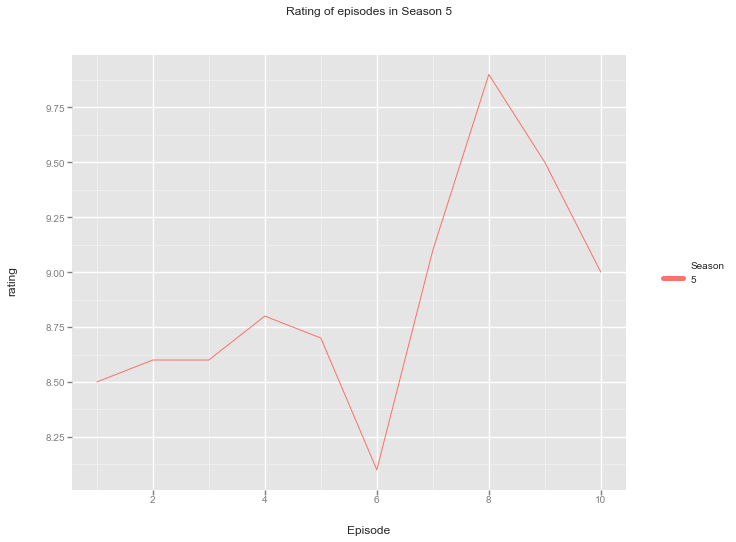

<ggplot: (157442167791)>

In [40]:
ggplot(data=got.loc[got.Season=="5",:], aesthetics= aes(x= "Episode", y= "rating", color= "Season")) + geom_line() + \
ggtitle('Rating of episodes in Season 5')

Looks like second last episode of Season 5 is rated the highest.. Let's validate it further for all seasons.. but obv not with line graph, it was a bad idea

In [41]:
got_pivot= got.pivot_table(index="Episode", columns="Season", values="rating")
got_pivot

Season,1,2,3,4,5,6,7
Episode,,,,,,,
1,9.0,8.8,8.8,9.1,8.5,8.5,8.7
2,8.8,8.6,8.6,9.7,8.6,9.5,9.0
3,8.7,8.9,8.9,8.9,8.6,8.8,9.3
4,8.8,8.8,9.6,8.9,8.8,9.2,9.8
5,9.1,8.9,9.0,8.8,8.7,9.7,9.0
6,9.2,9.1,8.8,9.7,8.1,8.5,9.3
7,9.3,9.0,8.8,9.2,9.1,8.6,9.6
8,9.0,8.8,9.0,9.7,9.9,8.4,NaN
9,9.6,9.7,9.9,9.6,9.5,9.9,NaN


In [42]:
got_title_matrix= got[["Episode", "Season", "title"]].set_index(["Episode", "Season"]).unstack()

I will center the rating across episodes in a season, it will give a clear visualization of which episode is being rated relatively higher in that season. \n
This is not done across the GOT series, since my assumption is that story plot is more consistent within a season. For example: It not not very correct to compare rating of episode 4 of season 5 to episode 4 of season 1

In [43]:
got_pivot_centered= np.round((got_pivot- got_pivot.mean(axis=0)),2)

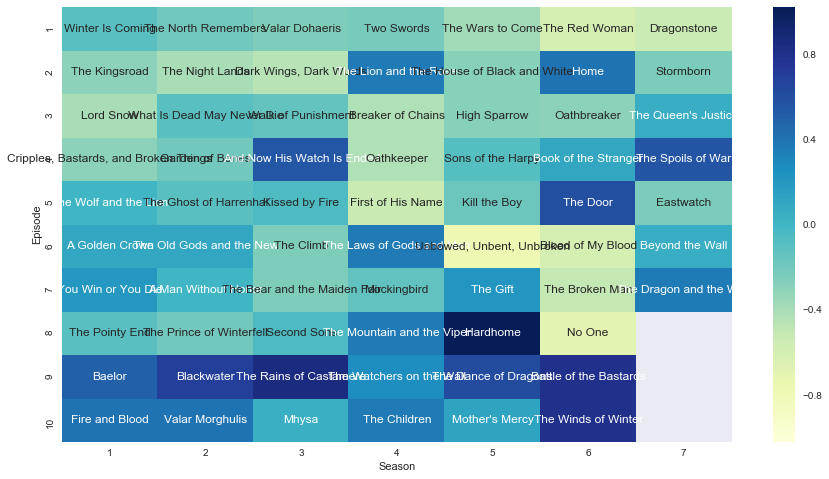

In [44]:
plt.figure(figsize=(15,8))
sns.heatmap(got_pivot_centered, cmap= 'YlGnBu', annot=got_title_matrix, fmt='')

From above heatmap, it does look like, episodes at the end of a season (semi-finale/finale) are more liked by the viewers. Some of the exceptions: 1. Season 6 episode 5 "The Door" where we lost our cute friend Hodor. And, 2. Season 7 episode 4 "The Spoils of War" where Daenerys surprisingly attacked the Lannister fleet. 